### Dummy Classifier & custom grid search with cross validation
##### No departure delay column

made with kaggle<br><br>
<br><br>



In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You canq write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/delaysenc/delays20enc.csv


In [3]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics

from sklearn.dummy import DummyClassifier
#from sklearn.model_selection import cross_val_score, StratifiedKFold
#from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

#from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
%matplotlib inline

In [4]:
df=pd.read_csv('/kaggle/input/delaysenc/delays20enc.csv', index_col=False, warn_bad_lines=True, error_bad_lines=False)
df=df.drop(['Unnamed: 0'], axis=1)
df = df.sample(frac =.02).reset_index().drop(['index'], axis=1)
df.head()

,CRSElapsedTime,Distance,ArrDelay,DepTime_sin,DepTime_cos,ArrTime_sin,ArrTime_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos,origin_freq,dest_freq,carrier
0,0.357858,-0.272727,1,-0.557745,-0.830012,-0.801254,-0.598325,-0.500000,0.866025,-0.781831,0.623490,0.008004,0.018277,0.073373
1,0.798298,0.815152,0,-0.999123,0.041876,-0.589901,0.807475,0.000000,1.000000,0.781831,0.623490,0.065680,0.004283,0.073456
2,0.407908,-0.090909,1,-0.661312,0.750111,-0.375416,0.926857,0.866025,-0.500000,0.974928,-0.222521,0.018547,0.003952,0.050037
3,0.780280,0.498485,1,0.117537,-0.993068,-0.397148,-0.917755,0.866025,0.500000,-0.781831,0.623490,0.029330,0.000521,0.052140
4,0.519520,-0.118182,1,-0.268920,-0.963163,-0.531399,-0.847122,0.500000,0.866025,0.781831,0.623490,0.002030,0.056216,0.073373


In [6]:
X,y = df.loc[:, df.columns != 'ArrDelay'],df.loc[:, df.columns == 'ArrDelay']

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

### Dummy Classifier

In [7]:
# Using the Dummy Classifier to set the lowest accuracy and therefore find the best model
dc = DummyClassifier(random_state=42) # define the model

# Train/fit the model to the data
dc.fit(X_train, y_train)

# Apply the model to the testing data to get a new set of predictions
# and show the accuracy score
prediction = dc.predict(X_test)
print('Arrival delay Dummy Classifier Accuracy:', metrics.accuracy_score(prediction, y_test))

Arrival delay Dummy Classifier Accuracy: 0.5379131561892417


### Support Vector Classification

In [9]:
kernel= ['linear', 'poly', 'rbf', 'sigmoid']

skf10 = StratifiedKFold(n_splits=10)
skf5 = StratifiedKFold(n_splits=5)

x=1
xx=[]
yy=[]

for k in kernel:
    clf = svm.SVC(kernel=k, random_state=42, gamma='auto')
    scores = cross_val_score(clf, X, y, cv=skf5, scoring='accuracy').mean()
    print(x,k, 'accuracy with 5 splits: ',scores)
    xx.append(x)
    yy.append(scores)
    x=x+1
    scores = cross_val_score(clf, X, y, cv=skf10, scoring='accuracy').mean()
    print(x,k, 'accuracy with 10 splits: ',scores)
    xx.append(x)
    yy.append(scores)
    x=x+1


1 linear accuracy with 5 splits:  0.6442370170125238
2 linear accuracy with 10 splits:  0.6442371793579431
3 poly accuracy with 5 splits:  0.6444964203847676
4 poly accuracy with 10 splits:  0.6442370113505778
5 rbf accuracy with 5 splits:  0.6442369329543993
6 rbf accuracy with 10 splits:  0.6442370113505778
7 sigmoid accuracy with 5 splits:  0.6275121400946326
8 sigmoid accuracy with 10 splits:  0.6250509062317292


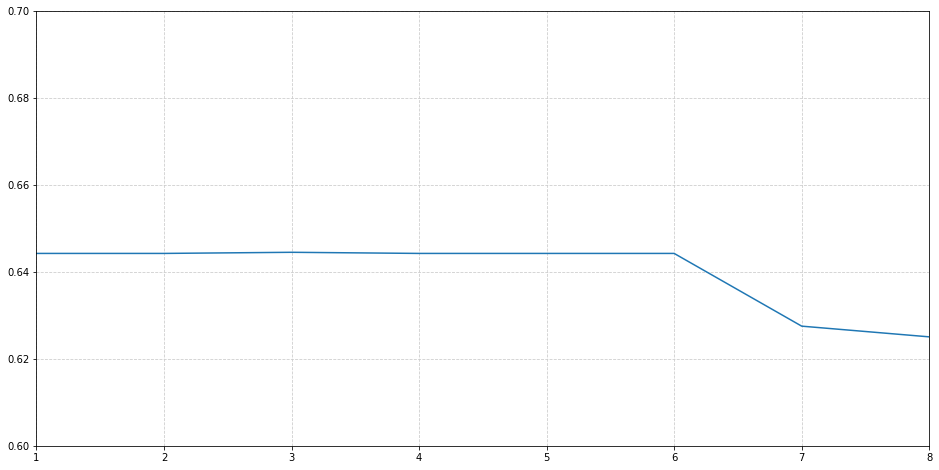

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(1, 8)
ax.set_ylim(0.6,0.7)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.plot(xx, yy)

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')




### Kneighbors Classifier

In [24]:
k_range = list(range(5, 35))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=skf5, scoring='accuracy')
    k_scores.append(scores.mean())
    print(k,'range: ',scores.mean())

5 range:  0.6031387303692758
6 range:  0.5755226103746219
7 range:  0.6163625864012447
8 range:  0.595099579457203
9 range:  0.622585493416988
10 range:  0.6039152593235171
11 range:  0.6295857699682176
12 range:  0.620641565229525
13 range:  0.6282916951413563
14 range:  0.6188273387281839
15 range:  0.6291991866535872
16 range:  0.6196047082636702
17 range:  0.6328284802375147
18 range:  0.6229740941266066
19 range:  0.6347734171224718
20 range:  0.6276431026526222
21 range:  0.635031727739097
22 range:  0.6324386186560282
23 range:  0.6407371729403448
24 range:  0.6346437154363499
25 range:  0.6412553072198364
26 range:  0.6397002319163655
27 range:  0.6408664543358442
28 range:  0.6390511350788843
29 range:  0.6404779376843499
30 range:  0.6393113790323733
31 range:  0.6416450847431983
32 range:  0.639699811625743
33 range:  0.641904151882944
34 range:  0.6404781898587235


Text(0, 0.5, 'Cross-Validated Accuracy')

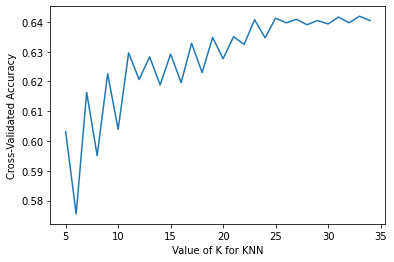

In [25]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

##### Linear Regression

In [41]:

lm = LinearRegression()
skf10 = StratifiedKFold(n_splits=10)
scores = -cross_val_score(lm, X, y, cv=skf10, scoring='neg_mean_squared_error')
print(scores)
skf5 = StratifiedKFold(n_splits=5)
scores = -cross_val_score(lm, X, y, cv=skf5, scoring='neg_mean_squared_error')
print(scores)

[0.22014253 0.22225223 0.22158272 0.21853956 0.21612135 0.2142613
 0.21423101 0.22034051 0.22483701 0.21672378]
[0.22091383 0.22017083 0.21544336 0.21730043 0.2210328 ]


### Decision Tree

In [20]:
depth=list(range(3, 13))
x=1
xx=[]
yy=[]

for dd in depth:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=dd, random_state=42)
    scores=cross_val_score(clf, X, y, cv=skf10, scoring='accuracy').mean()
    print(x,'Entropy, max depth ',dd,': ',scores, '10 folds')
    xx.append(x)
    yy.append(scores)
    x=x+1
    clf = DecisionTreeClassifier(criterion="gini", max_depth=dd, random_state=42)
    scores+cross_val_score(clf, X, y, cv=skf5, scoring='accuracy').mean()
    print(x,'Gini, max depth ',dd,': ',scores, '5 folds')
    xx.append(x)
    yy.append(scores)
    x=x+1

1 Entropy, max depth  3 :  0.6537037223711888 10 folds
2 Gini, max depth  3 :  0.6537037223711888 5 folds
3 Entropy, max depth  4 :  0.6556477355967287 10 folds
4 Gini, max depth  4 :  0.6556477355967287 5 folds
5 Entropy, max depth  5 :  0.6535723406114123 10 folds
6 Gini, max depth  5 :  0.6535723406114123 5 folds
7 Entropy, max depth  6 :  0.6525392633213041 10 folds
8 Gini, max depth  6 :  0.6525392633213041 5 folds
9 Entropy, max depth  7 :  0.6444984308112068 10 folds
10 Gini, max depth  7 :  0.6444984308112068 5 folds
11 Entropy, max depth  8 :  0.644886191810649 10 folds
12 Gini, max depth  8 :  0.644886191810649 5 folds
13 Entropy, max depth  9 :  0.6306215264477194 10 folds
14 Gini, max depth  9 :  0.6306215264477194 5 folds
15 Entropy, max depth  10 :  0.6278982950612555 10 folds
16 Gini, max depth  10 :  0.6278982950612555 5 folds
17 Entropy, max depth  11 :  0.6241381222152779 10 folds
18 Gini, max depth  11 :  0.6241381222152779 5 folds
19 Entropy, max depth  12 :  0.6183

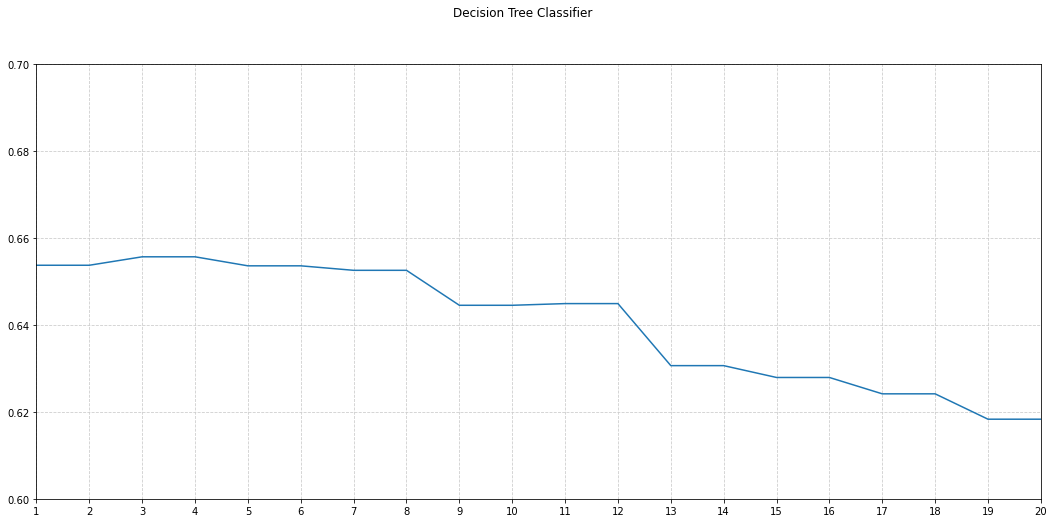

In [22]:
fig, ax = plt.subplots(figsize=(18, 8))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(1, 20)
ax.set_ylim(0.6,0.7)


fig.suptitle('Decision Tree Classifier')

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.plot(xx, yy)

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')

### neural network MLPClassifier

In [11]:
lst=[(20,10,5),(150,100,50)]
iter=(500,200,50)
cvs=(skf10,skf5)
activation=['relu', 'logistic', 'tanh']
quotes='n_(.*?),'
x=1
xx=[]
yy=[]

for hls in lst:
    for it in iter:
        for cv in cvs:
            for act in activation:
                xx.append(x)
                mlp = MLPClassifier(hidden_layer_sizes=hls, max_iter=it, activation = act,solver='adam',random_state=1)
                print (x ,'hidden layers:',hls,' max iterations:','activation:',act, it, re.findall(quotes,str(cv)))
                mean1=cross_val_score(mlp, X, y, cv=cv, scoring='accuracy').mean()
                print('mean accuracy: ',mean1)
                yy.append(mean1)
                x=x+1

1 hidden layers: (20, 10, 5)  max iterations: activation: relu 500 ['splits=10']
mean accuracy:  0.6455352042633549
2 hidden layers: (20, 10, 5)  max iterations: activation: logistic 500 ['splits=10']
mean accuracy:  0.6478688265693567
3 hidden layers: (20, 10, 5)  max iterations: activation: tanh 500 ['splits=10']
mean accuracy:  0.6518887388023091
4 hidden layers: (20, 10, 5)  max iterations: activation: relu 500 ['splits=5']
mean accuracy:  0.6473481763169596
5 hidden layers: (20, 10, 5)  max iterations: activation: logistic 500 ['splits=5']
mean accuracy:  0.6483864622709311
6 hidden layers: (20, 10, 5)  max iterations: activation: tanh 500 ['splits=5']
mean accuracy:  0.6474796432236963
7 hidden layers: (20, 10, 5)  max iterations: activation: relu 200 ['splits=10']
mean accuracy:  0.6420325867086012
8 hidden layers: (20, 10, 5)  max iterations: activation: logistic 200 ['splits=10']
mean accuracy:  0.6478688265693567
9 hidden layers: (20, 10, 5)  max iterations: activation: tanh 

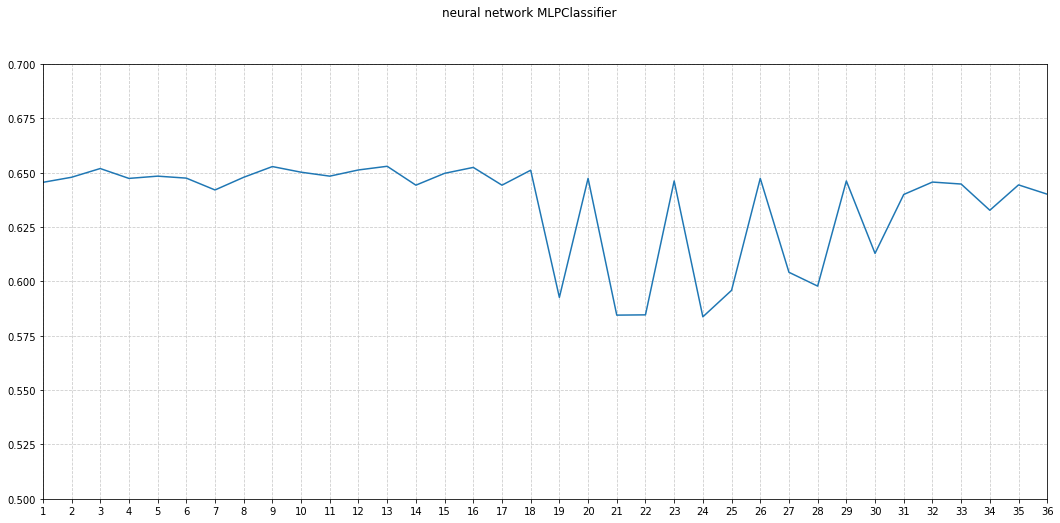

In [13]:
fig, ax = plt.subplots(figsize=(18, 8))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(1, 36)
ax.set_ylim(0.5,0.7)


fig.suptitle('neural network MLPClassifier')

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.plot(xx, yy)

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')

### Gaussian Process Classifier

gpc = GaussianProcessClassifier(kernel=1*RBF(1.0))
print('mean accuracy: ',cross_val_score(gpc, X, y, cv=skf5, scoring='accuracy').mean())

### Gaussian Naive Bayes

In [17]:
clf = GaussianNB()
print('10 folds accuracy: ',cross_val_score(clf, X, y, cv=skf10, scoring='accuracy').mean())
print('5 folds accuracy: ',cross_val_score(clf, X, y, cv=skf5, scoring='accuracy').mean())

10 folds accuracy:  0.6345135850755697
5 folds accuracy:  0.6342519205179997


### Ada Boost Classifier

In [15]:
estim=[200,100,50]
algorithm=['SAMME.R','SAMME']
cvs=(skf10,skf5)
quotes='n_(.*?),'
x=1
xx=[]
yy=[]


for n in estim:
    for alg in algorithm:
        for cv in cvs:
            ada = AdaBoostClassifier(n_estimators=n, random_state=42,algorithm=alg)
            print (x,'estimators:',n,' algorithm:', alg, re.findall(quotes,str(cv)))
            score=cross_val_score(ada, X, y, cv=cv, scoring='accuracy').mean()
            print('mean accuracy: ',score)
            xx.append(x)
            yy.append(score)
            x=x+1

1 estimators: 200  algorithm: SAMME.R ['splits=10']
mean accuracy:  0.649944557569404
2 estimators: 200  algorithm: SAMME.R ['splits=5']
mean accuracy:  0.6509804119352449
3 estimators: 200  algorithm: SAMME ['splits=10']
mean accuracy:  0.6588912857939693
4 estimators: 200  algorithm: SAMME ['splits=5']
mean accuracy:  0.6581124075675848
5 estimators: 100  algorithm: SAMME.R ['splits=10']
mean accuracy:  0.6521491502187456
6 estimators: 100  algorithm: SAMME.R ['splits=5']
mean accuracy:  0.6551291847286562
7 estimators: 100  algorithm: SAMME ['splits=10']
mean accuracy:  0.6599280592461174
8 estimators: 100  algorithm: SAMME ['splits=5']
mean accuracy:  0.6588901973936937
9 estimators: 50  algorithm: SAMME.R ['splits=10']
mean accuracy:  0.6548728856273061
10 estimators: 50  algorithm: SAMME.R ['splits=5']
mean accuracy:  0.6594081635569362
11 estimators: 50  algorithm: SAMME ['splits=10']
mean accuracy:  0.6604451859169507
12 estimators: 50  algorithm: SAMME ['splits=5']
mean accura

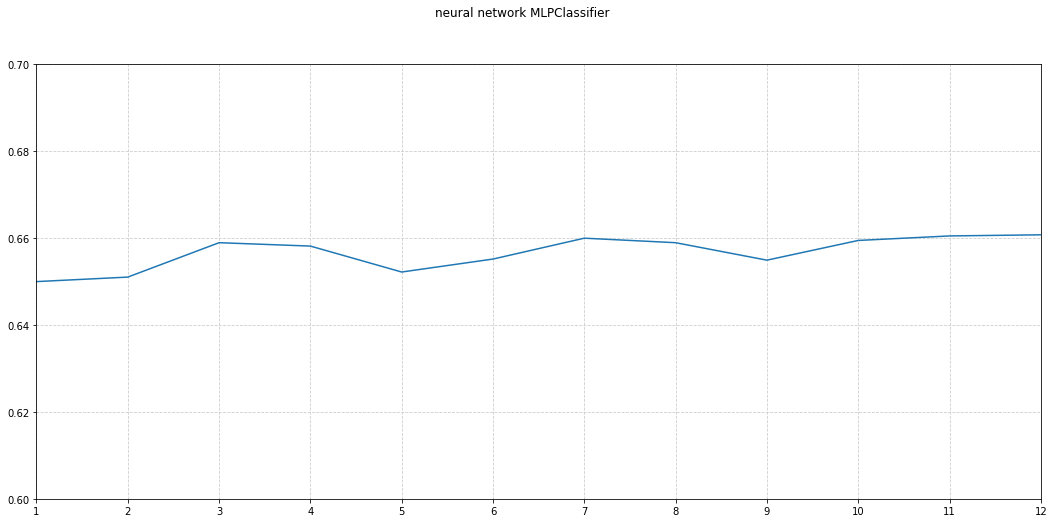

In [16]:
fig, ax = plt.subplots(figsize=(18, 8))

# Set axis ranges; by default this will put major ticks every 25.
ax.set_xlim(1, 12)
ax.set_ylim(0.6,0.7)


fig.suptitle('neural network MLPClassifier')

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1))

ax.plot(xx, yy)

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')